In [1]:
import pandas as pd
import os
import gc
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
import lightgbm as lgbm
from sklearn import metrics
import re
import pickle

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [68]:
with open('./data/spark_data/last_answers.pickle', 'rb') as fo:
    last_answers = pickle.load(fo)

In [69]:
last_answers

,user_id,timestamp,bundle_id,prior_question_elapsed_time,answers_count,correct_answers_count,explanations_count,bundle_id_str,prior_bundle_id,user_bundles_list,attempts,user_answers_count,user_correct_answers_count,user_explanation_count,user_elapsed_time
0,1545183603,429335,10686,15000.0,1,0,1,None,None,,0,15,8,7,314000.0
1,703344073,3424924618,5252,31000.0,1,1,1,None,None,,0,489,259,458,13413499.0
2,1644302997,435094,7216,15500.0,4,1,0,None,None,,0,30,9,0,219498.0
3,847253606,4527028589,8889,9000.0,1,0,1,None,None,,0,90,57,82,1689000.0
4,590265240,534154,706,16000.0,1,1,1,None,None,,0,17,12,9,327000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393651,1984156215,245651,3577,17000.0,1,0,0,None,None,,0,10,6,0,194000.0
393652,390568760,577678,7216,10250.0,4,0,0,None,None,,0,30,5,0,263916.0
393653,1153587543,776065,9312,28000.0,1,1,1,None,None,,0,21,12,9,512000.0
393654,921247457,798832,7216,22500.0,4,3,0,None,None,,0,30,17,0,286165.0


In [2]:
def memory_usage(df, name):
    mb = df.memory_usage().sum() / 1024 / 1024
    print(name + ' use {:.2f} mb in memory'.format(mb))

In [8]:
df = pd.DataFrame({
    'content_id': [1, 1, 3, 4, 1, 5] + [1, 2, 1, 3],
    'timestamp': [1, 2, 4, 5, 3, 6] + [1, 2, 3, 4],
    'user_id': [1] * 6 + [2] * 4
})
df = df.sort_values(['user_id', 'timestamp'])
df['content_id'] = ' ' + df['content_id'].astype(str) + ','

# df['rolling'] = ''

In [92]:
df['prior_content_id'] = (
    df
    .groupby(['user_id'])['content_id'].shift(1)
).fillna('-1, 10, 11')#.astype(int).astype(str)
df['prior_content_id'] = ' ' + df['prior_content_id'] + ','
#df.loc[df['prior_content_id'] == '-1', 'prior_content_id'] = '11, 9, 10'
df

,content_id,timestamp,user_id,prior_content_id
0,1,1,1,"-1, 10, 11,"
1,1,2,1,"1,"
4,1,3,1,"1,"
2,3,4,1,"1,"
3,4,5,1,"3,"
5,5,6,1,"4,"
6,1,1,2,"-1, 10, 11,"
7,2,2,2,"1,"
8,1,3,2,"2,"
9,3,4,2,"1,"


In [12]:
%%time
df['rolling_list'] = df.groupby('user_id')['content_id'].apply(lambda x: x.cumsum())
df['rolling_list']

CPU times: user 1.89 ms, sys: 388 µs, total: 2.28 ms
Wall time: 1.89 ms


0                    1,
1                 1, 1,
4              1, 1, 1,
2           1, 1, 1, 3,
3        1, 1, 1, 3, 4,
5     1, 1, 1, 3, 4, 5,
6                    1,
7                 1, 2,
8              1, 2, 1,
9           1, 2, 1, 3,
Name: rolling_list, dtype: object

In [7]:
%%time
for user_id in df['user_id'].unique():
    index = df['user_id'] == user_id
    df.loc[index, 'rolling_list'] = df.loc[index, 'content_id'].cumsum()
df['rolling_list']
#df['secondary_answer'] = df.apply(lambda x: len(re.findall(' ' + x.content_id + ',', x.rolling_list)), axis=1)

CPU times: user 2.57 ms, sys: 112 µs, total: 2.68 ms
Wall time: 2.59 ms


0         1
1        11
4       111
2      1113
3     11134
5    111345
6         1
7        12
8       121
9      1213
Name: rolling_list, dtype: object

In [94]:
df

,content_id,timestamp,user_id,prior_content_id,rolling_list,secondary_answer
0,1,1,1,"-1, 10, 11,","-1, 10, 11,",0
1,1,2,1,"1,","-1, 10, 11, 1,",1
4,1,3,1,"1,","-1, 10, 11, 1, 1,",2
2,3,4,1,"1,","-1, 10, 11, 1, 1, 1,",0
3,4,5,1,"3,","-1, 10, 11, 1, 1, 1, 3,",0
5,5,6,1,"4,","-1, 10, 11, 1, 1, 1, 3, 4,",0
6,1,1,2,"-1, 10, 11,","-1, 10, 11,",0
7,2,2,2,"1,","-1, 10, 11, 1,",0
8,1,3,2,"2,","-1, 10, 11, 1, 2,",1
9,3,4,2,"1,","-1, 10, 11, 1, 2, 1,",0


In [20]:
df_answers = df\
                            .groupby(['user_id', 'timestamp'])['prior_content_id']\
                            .agg(lambda x: list(x))\
                            .cumsum()\
                            .reset_index()
df_answers.columns = ['user_id', 'timestamp', 'questions_list_rol']
df_answers['questions_list_rol'] = ' ' + df_answers['questions_list_rol'].astype('str').str.replace(r'[\[\]\']', '', regex=True) + ','
df = df.merge(df_answers, on=['user_id', 'timestamp'], how='left')
df['secondary_answer'] = df.apply(lambda x: len(re.findall(' ' + str(x.content_id) + ',', x.questions_list_rol)), axis=1).astype(int)

In [21]:
df

,content_id,timestamp,user_id,prior_content_id,questions_list_rol,secondary_answer
0,1,1,1,-1,"-1,",0
1,1,2,1,1,"-1, 1,",1
2,1,3,1,1,"-1, 1, 1,",2
3,3,4,1,1,"-1, 1, 1, 1,",0
4,4,5,1,3,"-1, 1, 1, 1, 3,",0
5,5,6,1,4,"-1, 1, 1, 1, 3, 4,",0
6,1,1,2,-1,"-1, 1, 1, 1, 3, 4, -1,",3
7,2,2,2,1,"-1, 1, 1, 1, 3, 4, -1, 1,",0
8,1,3,2,2,"-1, 1, 1, 1, 3, 4, -1, 1, 2,",4
9,3,4,2,1,"-1, 1, 1, 1, 3, 4, -1, 1, 2, 1,",1


# TODO
* попробовать собирать cumsum через стринг, заместо листа:
    * переводим контент в стринг
    * добавляем пробел в начале
    * проходимся камсумом
    * сплитим в set с разделитилем пробелом
    * в last_answers переводим set. в стринг
* добавить гармоническое среднее между точностью пользователя и всех пользователей
* добавить номер попытки ответа пользователя на конкретный вопрос
* добавить в признаки part
* добавить в признаки количество ответов пользователя

# Загрузка данных

In [3]:
data_path = './data'
#data_path = '/kaggle/input'
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        current_file_path = os.path.join(dirname, filename)
        if 'lectures.csv' in current_file_path:
            lectures_path = current_file_path
        if 'questions.csv' in current_file_path:
            questions_path = current_file_path
        if 'train.csv' in current_file_path:
            data_path = current_file_path
        print(current_file_path)

./data/last_answers.pickle
./data/.DS_Store
./data/q_chars.pickle
./data/valid_df.pickle
./data/train_df.pickle
./data/riiid-test-answer-prediction/lectures.csv
./data/riiid-test-answer-prediction/example_sample_submission.csv
./data/riiid-test-answer-prediction/questions.csv
./data/riiid-test-answer-prediction/train.csv
./data/riiid-test-answer-prediction/example_test.csv
./data/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
./data/riiid-test-answer-prediction/riiideducation/__init__.py


In [4]:
# with open(data_path) as f:
#     row_count = sum(1 for line in f)
# print(row_count)
#101230333

In [60]:
%%time
lectures_df = pd.read_csv(lectures_path)
questions_df = pd.read_csv(questions_path)
data = pd.read_csv(data_path, low_memory=False, nrows=1e7, 
                   dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 
                          'content_id': 'int16', 'content_type_id': 'int8', 'task_container_id': 'int16', 
                          'user_answer': 'int8', 'answered_correctly': 'int8', 
                          'prior_question_elapsed_time': 'float32', 
                          'prior_question_had_explanation': 'boolean'
                         }
                  )
# test_data = pd.read_csv('./data/riiid-test-answer-prediction/example_test.csv')
memory_usage(lectures_df, 'lectures')
memory_usage(questions_df, 'questions')
memory_usage(data, 'train')

lectures use 0.01 mb in memory
questions use 0.52 mb in memory
train use 314.71 mb in memory
CPU times: user 9.09 s, sys: 1.23 s, total: 10.3 s
Wall time: 10.3 s


# Формирование массива

In [61]:
def merge_data(data, questions_df, lectures_df=None, data_type='train'):
    # Согласованность колонок теста и трейна оставляет желать лучшего
    if data_type == 'train':
        data_columns = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
                        'task_container_id', 'user_answer', 'answered_correctly',
                        'prior_question_elapsed_time', 'prior_question_had_explanation']
        data = data.loc[data['content_type_id'] != 1, data_columns]
    else:
        data_columns = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
                        'task_container_id',
                        'prior_question_elapsed_time', 'prior_question_had_explanation']
        data = data.loc[data['content_type_id'] != 1, data_columns]
    data.drop(columns='content_type_id', inplace=True)
    
    # Собираем общий массив
    questions_df.columns = ['content_id', 'bundle_id', 'correct_answer', 'part', 'tags']
    if lectures_df is None:
        full_df = (
            data
            .merge(questions_df, on='content_id', how='left')
        )
    else:
        lectures_df.columns = ['content_id', 'lecture_tag', 'lecture_part', 'type_of_lecture']
        full_df = (
            data
            .merge(questions_df, on='content_id', how='left')
            .merge(lectures_df, on='content_id', how='left')
        )
        # Уменьшаем размер массива путём объединения колонок и заполенения наллов
        full_df.loc[full_df['part'].isnull(), 'part'] = full_df.loc[full_df['part'].isnull(), 'lecture_part']
        full_df.loc[full_df['tags'].isnull(), 'tags'] = full_df.loc[full_df['tags'].isnull(), 'lecture_tag'].astype(str)
        full_df.drop(columns=['lecture_part', 'lecture_tag'], inplace=True)
        full_df.loc[full_df['correct_answer'].isnull(), 'correct_answer'] = -1
    
    # Заполнение наллов в просмотре ответов
    index = full_df['prior_question_had_explanation'].isnull()
    full_df.loc[index, 'prior_question_had_explanation'] = False
    
    # Приводим типы
    full_df['part'] = full_df['part'].astype('int8')
    full_df['prior_question_had_explanation'] = full_df['prior_question_had_explanation'].astype('int8')
    
    # Если обучающая выборка, то можем проверить правильность ответа
    if data_type == 'train':
        full_df['correct_answer'] = full_df['correct_answer'].astype('int8')
        # Убеждаемся в правильности ответов
        full_df['answered_correctly_really'] = (full_df['user_answer'] == full_df['correct_answer']).astype('int8')
        index_dev = (
            full_df['answered_correctly_really'] != full_df['answered_correctly']
        )
        deviations_count = index_dev.sum()
        if deviations_count > 0:
            print('Wrong answer_correctly in {} rows'.format(deviations_count))
            full_df.loc[index_dev, 'answered_correctly'] = full_df.loc[index_dev, 'answered_correctly_really']
        full_df.drop(columns=['answered_correctly_really', 'correct_answer'], inplace=True)
    else:
        full_df.drop(columns=['correct_answer'], inplace=True)
    
    memory_usage(full_df, 'merged_df')
    
    return full_df

In [62]:
def get_users_last_answers(data):
    users_last_timestamps = data.groupby('user_id')['timestamp'].max().reset_index()
    merge_cols = ['user_id', 'timestamp']
    users_last_timestamps.columns = merge_cols
    output = data.merge(users_last_timestamps, on=merge_cols, how='inner')
    output.loc[:, 'old_data'] = True
    return output

In [63]:
def get_answer_time_characteristics(full_df, last_answers=None):
    # Пользователи, участвующие в расчётах
    full_df_users = list(full_df.user_id.unique())
    # если датафрейм тестовый то правильности ответов мы не знаем, присвоим 0
    if 'answered_correctly' not in full_df.columns:
        full_df.loc[:, 'answered_correctly'] = 0
    # Колонка для составления списка пачек вопросов, на которые пользователь уже ответил
    full_df.loc[:, 'bundle_id_str'] = ' ' + full_df.loc[:, 'bundle_id'].astype(str) + ','
    # У пачки вопросов временные характеристики одинаковые, нужно объединять
    group_cols = ['timestamp', 'user_id', 'bundle_id', 'bundle_id_str',
                  'prior_question_elapsed_time', 'prior_question_had_explanation']
    aggregates = {
        'row_id': ['count'], # количество вопросов в пачке
        'answered_correctly': ['sum'] # количество правильных ответов в пачке
    }
    new_cols = group_cols + ['answers_count', 'correct_answers_count']
        
    bundles = full_df.groupby(group_cols, dropna=False).agg(aggregates).reset_index()
    bundles.columns = new_cols
    bundles['explanations_count'] = bundles['prior_question_had_explanation'] * bundles['answers_count']
    bundles.drop(columns='prior_question_had_explanation', inplace=True)
    
    
    # Сортируем по таймстемпу, чтобы потом нигде этим не заниматься
    bundles = bundles.sort_values(['user_id', 'timestamp'], ascending=True)
    
    # Колонки, которые получим с пачек вопросов
    rolling_cols = ['question_elapsed_time', 'prior_bundle_id', 
                    'user_bundles_list', 'attempts',
                    'user_explanation_count', 'user_elapsed_time', 
                    'user_answers_count', 'user_correct_answers_count']
    
    # Добавляем данные с пердыдущего расчёта
    full_df.loc[:, 'old_data'] = False
    if last_answers is not None:
        last_answers.loc[:, 'bundle_id_str'] = last_answers.loc[:, 'user_bundles_list'].astype(str)
        
        index = last_answers.user_id.isin(full_df_users)
        # К массиву исходных данных
        full_df = pd.concat([full_df, last_answers.loc[index, full_df.columns]])
        
        # К массиву групп вопросов
        columns = group_cols + rolling_cols
        bundle_update = last_answers.loc[index, columns].drop_duplicates()
        # Переименовываем поля, для корректного заполнения cumsum
        bundle_update.loc[:, 'prior_question_elapsed_time'] = bundle_update.loc[:, 'user_elapsed_time']
        bundle_update.loc[:, 'answers_count'] = bundle_update.loc[:, 'user_answers_count']
        bundle_update.loc[:, 'explanations_count'] = bundle_update.loc[:, 'user_explanation_count']
        if 'answered_correctly' in full_df.columns:
            bundle_update.loc[:, 'correct_answers_count'] = bundle_update.loc[:, 'user_correct_answers_count']
        bundles = pd.concat([bundles, bundle_update.loc[:, bundles.columns]]).reset_index()
        
        # Оставляем в последних результатах только те, которые не обновятся
        last_answers = last_answers.loc[~index, :]
        
    # Время ответа на текущий вопрос для сбора метрик по вопросам
    bundles['question_elapsed_time'] = (
        bundles
        .groupby(['user_id'])['prior_question_elapsed_time'].shift(-1)
    )
    
    # Предыдущая пачка вопросов
    bundles['prior_bundle_id'] = (
        bundles
        .groupby(['user_id'])['bundle_id_str'].shift(1)
        .fillna('-1')
    )
    print('start kraken')
    # пачки, на которые пользователь уже отвечал
    for user_id in full_df_users:
        index = bundles['user_id'] == user_id
        bundles.loc[index, 'user_bundles_list'] = bundles.loc[index, 'prior_bundle_id'].cumsum()
    print('end kraken')
    
    # Ищем номер попытки ответа именно на этот вопрос (нумерация с нуля)
#     bundles['attempts'] = bundles.apply(lambda x: len(re.findall(' ' + str(x.bundle_id) + ',', x.user_bundles_list)), axis=1).astype('int8')
    bundles['attempts'] = bundles.apply(lambda x: ' ' + str(x.bundle_id) + ',' in x.user_bundles_list, axis=1).astype('int8')
    print('end attempts')
    
    # Количество объяснений, которые получил пользователь
    bundles['user_explanation_count'] = bundles\
                                        .groupby(['user_id'])['explanations_count']\
                                        .cumsum()
    
    # Сумарное время ответов с начала теста до ответа на текущий вопрос
    bundles['user_elapsed_time'] = bundles\
                                   .groupby(['user_id'])['prior_question_elapsed_time']\
                                   .cumsum()
    # Количество ответов пользователя до текущего момента
    bundles['user_answers_count'] = bundles\
                                    .groupby(['user_id'])['answers_count']\
                                    .cumsum()
    # Количество правильных ответов до текущего момента
    bundles['user_correct_answers_count'] = bundles\
                                              .groupby(['user_id'])['correct_answers_count']\
                                              .cumsum()
    
    
    # Колонки, которые в итоге получим
    merge_cols = ['user_id', 'bundle_id', 'timestamp']
    bundle_cols = merge_cols + rolling_cols
    # Добавляем данные к итоговому массиву
    full_df = full_df.merge(bundles[bundle_cols], 
                            on=merge_cols,
                            how='left')
    
    if last_answers is not None:
        last_answers = pd.concat([last_answers, get_users_last_answers(full_df)])
    else:
        last_answers = get_users_last_answers(full_df)
    # Убираем добавочные символы из списка вопросов
    last_answers['user_bundles_list'] = last_answers['user_bundles_list'].str.slice(1, -1)
    # В полном массиве список вопросов уже не нужен
    full_df.drop(columns='user_bundles_list', inplace=True)
        
    memory_usage(full_df, 'full_df')
    memory_usage(last_answers, 'last_answers')
    
    return full_df, last_answers

In [64]:
%%time
merged_df = merge_data(data, questions_df)
full_df, last_answers = get_answer_time_characteristics(merged_df)
#full_df, last_answers = get_answer_time_characteristics(merged_df, last_answers)

merged_df use 523.62 mb in memory
start kraken


KeyboardInterrupt: 

In [34]:
full_df

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,...,tags,bundle_id_str,old_data,question_elapsed_time,prior_bundle_id,attempts,user_explanation_count,user_elapsed_time,user_answers_count,user_correctly_answers_count
0,0,0,115,5692,1,3,1,NaN,0,5692,...,151,"5692,",False,37000.0,-1,0,0,NaN,1,1
1,1,56943,115,5716,2,2,1,37000.0,0,5716,...,168,"5716,",False,55000.0,"5692,",0,0,37000.0,2,2
2,2,118363,115,128,0,0,1,55000.0,0,128,...,131 149 92,"128,",False,19000.0,"5716,",0,0,92000.0,3,3
3,3,131167,115,7860,3,0,1,19000.0,0,7860,...,131 104 81,"7860,",False,11000.0,"128,",0,0,111000.0,4,4
4,4,137965,115,7922,4,1,1,11000.0,0,7922,...,131 149 92,"7922,",False,5000.0,"7860,",0,0,122000.0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98177,99995,153647401,2078569,4334,275,3,0,6000.0,1,4334,...,66,"4334,",False,9000.0,"3644,",0,238,5289000.0,276,216
98178,99996,153692472,2078569,6436,276,3,0,9000.0,1,6436,...,28,"6436,",False,21000.0,"4334,",0,239,5298000.0,277,216
98179,99997,153722998,2078569,6446,277,2,1,21000.0,1,6446,...,91,"6446,",False,12000.0,"6436,",0,240,5319000.0,278,217
98180,99998,153759775,2078569,3715,278,3,0,12000.0,1,3715,...,60,"3715,",False,16000.0,"6446,",0,241,5331000.0,279,217


In [65]:
last_answers

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,...,bundle_id_str,old_data,question_elapsed_time,prior_bundle_id,user_bundles_list,attempts,user_explanation_count,user_elapsed_time,user_answers_count,user_correctly_answers_count
0,43,668090043,115,3363,41,1,0,14333.0,0,3363,...,"3363,",True,NaN,"2063,","1 5692, 5716, 128, 7860, 7922, 156, 51, 50, 78...",0,6,834333.0,46,32
1,44,668090043,115,3365,41,0,0,14333.0,0,3363,...,"3363,",True,NaN,"2063,","1 5692, 5716, 128, 7860, 7922, 156, 51, 50, 78...",0,6,834333.0,46,32
2,45,668090043,115,3364,41,1,1,14333.0,0,3363,...,"3363,",True,NaN,"2063,","1 5692, 5716, 128, 7860, 7922, 156, 51, 50, 78...",0,6,834333.0,46,32
3,72,571323,124,7218,15,3,0,6500.0,0,7216,...,"7216,",True,NaN,"6908,","1 7900, 7876, 175, 1278, 2063, 3363, 2946, 259...",0,0,316499.0,30,7
4,73,571323,124,7216,15,0,0,6500.0,0,7216,...,"7216,",True,NaN,"6908,","1 7900, 7876, 175, 1278, 2063, 3363, 2946, 259...",0,0,316499.0,30,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,99166,867885,2058478,3702,16,1,1,32000.0,1,3702,...,"3702,",True,NaN,"8727,","1 4363, 5188, 8275, 9737, 3928, 5199, 6344, 53...",0,9,643000.0,17,7
577,99265,20300691390,2066347,6180,84,3,0,28000.0,1,6180,...,"6180,",True,NaN,"3880,","1 7900, 7876, 175, 1278, 2063, 3363, 2946, 259...",0,67,1980415.0,98,52
578,99322,89062366,2067931,4995,56,3,1,10000.0,1,4995,...,"4995,",True,NaN,"3970,","1 5497, 3616, 4554, 4938, 3986, 5056, 6310, 46...",0,49,932000.0,57,46
579,99719,18250788722,2073472,5339,334,3,0,9000.0,1,5339,...,"5339,",True,NaN,"9305,","1 7900, 7876, 175, 1278, 2063, 3363, 2946, 259...",0,365,6210415.0,396,261


# Сбор статистик

In [9]:
def get_questions_characteristics(full_df, questions_characteristics=None):
    # Время, затраченное на ответ
    q_time = (
        full_df
        .groupby('bundle_id').
        agg({'question_elapsed_time': ['sum', 'count']}).
        reset_index()
    )
    q_time.columns = ['bundle_id', 'question_bundle_time_sum', 'question_bundle_count']
    # Характеристики правильности ответов
    q_answer = (
        full_df
        .groupby(['content_id', 'bundle_id'])
        .agg({'answered_correctly': ['sum', 'count']})
        .reset_index()
    )
    q_answer.columns = ['content_id', 'bundle_id', 'question_answered_correctly_sum', 'question_answer_count']
    # Итоговый массив харастеристик вопросов
    q_chars = q_answer.merge(q_time, on='bundle_id', how='left')
    
    # Обновляем характеристики ответов
    if questions_characteristics is not None:
        columns = q_chars.columns
        columns_key = ['content_id', 'bundle_id']
        columns_renamed = [col + '_new' if col not in columns_key else col for col in columns]
        q_chars.columns = columns_renamed
        questions_characteristics = (
            questions_characteristics[columns]
            .merge(q_chars, on=['content_id', 'bundle_id'], how='outer')
            .fillna(0.)
        )
        for col in columns:
            if col in columns_key:
                continue
            questions_characteristics.loc[:, col] += questions_characteristics.loc[:, col + '_new']
        
        questions_characteristics = questions_characteristics[columns]
    else:
        questions_characteristics = q_chars
    # Пересчитываем средние показатели
    questions_characteristics['question_bundle_time_mean'] = questions_characteristics['question_bundle_time_sum'] / questions_characteristics['question_bundle_count']
    questions_characteristics['question_answered_correctly_mean'] = questions_characteristics['question_answered_correctly_sum'] / questions_characteristics['question_answer_count']
    
    memory_usage(questions_characteristics, 'questions_characteristics')
    
    return questions_characteristics

In [10]:
def read_train_data(path, nrows=None, skiprows=None):
    dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 
           'content_id': 'int16', 'content_type_id': 'int8', 'task_container_id': 'int16', 
           'user_answer': 'int8', 'answered_correctly': 'int8', 
           'prior_question_elapsed_time': 'float32', 
           'prior_question_had_explanation': 'boolean'
          }
    params = {
        'low_memory': False,
        'dtype': dtype
    }
    if nrows:
        params['nrows'] = nrows
    if skiprows:
        params['skiprows'] = skiprows
        params['names'] = list(dtype.keys())
    
    return pd.read_csv(path, **params)
                           
def read_data_partly(data_path='./data', rows_in_part=2e7, total_rows=None):
    for dirname, _, filenames in os.walk(data_path):
        for filename in filenames:
            current_file_path = os.path.join(dirname, filename)
            if 'questions.csv' in current_file_path:
                questions_path = current_file_path
            if 'train.csv' in current_file_path:
                data_path = current_file_path
                
    questions_df = pd.read_csv(questions_path)
    memory_usage(questions_df, 'questions')
    
    # Расчёт кусков для чтения
    if total_rows is None:
        with open(data_path) as f:
            total_rows = sum(1 for line in f)
    print('Total rows in train.csv {:.0f}'.format(total_rows))
    skiprows_list = [int(i * rows_in_part + 1) for i in range(1, int(total_rows // rows_in_part) - 1)]
    
    print('========Iteration 0=========')
    train_df = read_train_data(data_path, int(rows_in_part))
    memory_usage(train_df, 'train')
    
    train_df = merge_data(train_df, questions_df)
    train_df, last_answers = get_answer_time_characteristics(train_df)
    
    q_chars = get_questions_characteristics(train_df)
    
    for i, skiprows in enumerate(skiprows_list):
        print('========Iteration {}========='.format(i + 1))
        train_df = read_train_data(data_path, rows_in_part, skiprows)
        memory_usage(train_df, 'train')

        train_df = merge_data(train_df, questions_df)
        train_df, last_answers = get_answer_time_characteristics(train_df, last_answers)

        q_chars = get_questions_characteristics(train_df, q_chars)
        
    print('========Iteration last=========')
    train_df = read_train_data(data_path, rows_in_part, int(skiprows + rows_in_part + 1))
    memory_usage(train_df, 'train')
    
    valid_data = train_df.groupby('user_id')['timestamp'].max().reset_index()
    _, valid_data = train_test_split(valid_data, test_size=0.5, shuffle=True, random_state=13)
    
    train_df = merge_data(train_df, questions_df)
    train_df, last_answers = get_answer_time_characteristics(train_df, last_answers)
    
    valid_df = train_df.merge(valid_data, on=['user_id', 'timestamp'], how='inner')
    valid_data_indices = valid_df['row_id']
    train_df = train_df[~train_df.row_id.isin(valid_data_indices)]
    
    q_chars = get_questions_characteristics(train_df, q_chars)
        
    return train_df, valid_df, last_answers, q_chars, questions_df

In [9]:
%%time
#train_df, valid_df, last_answers, q_chars, questions_df = read_data_partly(rows_in_part=2e7)

questions use 0.52 mb in memory
Total rows in train.csv 101230333
========Iteration 0=========
train use 629.43 mb in memory
merged_df use 1066.00 mb in memory
full_df use 1832.76 mb in memory
last_answers use 12.43 mb in memory
questions_characteristics use 0.93 mb in memory
========Iteration 1=========
train use 629.43 mb in memory
merged_df use 1066.25 mb in memory
full_df use 1833.21 mb in memory
last_answers use 24.65 mb in memory
questions_characteristics use 0.93 mb in memory
========Iteration 2=========
train use 629.43 mb in memory
merged_df use 1066.28 mb in memory
full_df use 1833.26 mb in memory
last_answers use 36.97 mb in memory
questions_characteristics use 0.93 mb in memory
========Iteration 3=========
train use 629.43 mb in memory
merged_df use 1066.11 mb in memory
full_df use 1832.97 mb in memory
last_answers use 49.50 mb in memory
questions_characteristics use 0.93 mb in memory
========Iteration last=========
train use 629.43 mb in memory
merged_df use 1066.05 mb in 

In [10]:
# import pickle
# with open('./data/train_df.pickle', 'wb') as fo:
#     pickle.dump(train_df, fo)
# with open('./data/valid_df.pickle', 'wb') as fo:
#     pickle.dump(valid_df, fo)
# with open('./data/last_answers.pickle', 'wb') as fo:
#     pickle.dump(last_answers, fo)
# with open('./data/q_chars.pickle', 'wb') as fo:
#     pickle.dump(q_chars, fo)

# Подготовка признаков

In [11]:
# train_df_small = read_train_data(data_path, 1e6)
# memory_usage(train_df_small, 'train')

# train_df_small = merge_data(train_df_small, questions_df)
# train_df_small, last_answers_small = get_answer_time_characteristics(train_df_small)

# q_chars_small = get_questions_characteristics(train_df_small)

In [11]:
def norm_column(df, col):
    mean = df[col].mean()
    std = df[col].std()
    df.loc[:, col] = (df.loc[:, col] - mean) / (std + 0.0001)
    return df
def get_features_df(full_df, questions_characteristics, questions_df):
    # Характеристики задаваемых вопросов
    q_chars_current = questions_characteristics[['content_id', 'bundle_id', 
                                                 'question_bundle_time_mean', 'question_answered_correctly_mean']]
    q_chars_current = norm_column(q_chars_current, 'question_bundle_time_mean')
    q_chars_current.columns = ['content_id', 'bundle_id', 'question_time_rate', 'question_correct_rate']
    # Характеристики предыдущих вопросов
    q_chars_prior = questions_characteristics[['bundle_id', 'question_bundle_time_mean']].drop_duplicates()
    q_chars_prior.columns = ['prior_bundle_id', 'prior_question_bundle_time_mean']
    
    # Приводим id предыдущей пачки к int
    index = full_df.prior_bundle_id.isnull()
    full_df.loc[index, 'prior_bundle_id'] = -1.
    full_df.loc[:, 'prior_bundle_id'] = full_df.loc[:, 'prior_bundle_id'].astype(int)
    
    # Формируем общий массив
    output = (
        full_df.loc[~full_df['old_data'], 
                    ['row_id', 'user_id', 'content_id',
                     'prior_question_elapsed_time', 'prior_question_had_explanation',
                     'bundle_id', 'prior_bundle_id', 'user_elapsed_time', 
                     'user_answers_count', 'user_correctly_answers_count']
                   ]
        .merge(q_chars_current, on=['content_id', 'bundle_id'], how='left')
        .merge(q_chars_prior, on=['prior_bundle_id'], how='left')
    )
    
    # Формируем признаки
    output['prior_question_time_dev'] = (output['prior_question_elapsed_time'] - output['prior_question_bundle_time_mean']) / output['prior_question_bundle_time_mean']
    index = output['prior_question_time_dev'].isnull()
    output.loc[index, 'prior_question_time_dev'] = 0.
    
    index = output['prior_question_had_explanation'].isnull()
    output.loc[index, 'prior_question_had_explanation'] = False
    output.loc[:, 'prior_question_had_explanation'] = output.loc[:, 'prior_question_had_explanation'].astype(int)
    
    output['user_elapsed_time_mean'] = output['user_elapsed_time'] / output['user_answers_count']
    output = norm_column(output, 'user_elapsed_time_mean')
    index = output['user_elapsed_time_mean'].isnull()
    output.loc[index, 'user_elapsed_time_mean'] = 0.
    
    output['user_corect_answer_rate'] = output['user_correctly_answers_count'] / output['user_answers_count']
    index = output['user_corect_answer_rate'].isnull()
    output.loc[index, 'user_corect_answer_rate'] = 0.
    
    index = output['question_time_rate'].isnull()
    output.loc[index, 'question_time_rate'] = 0.
    output.loc[index, 'question_correct_rate'] = 0.5
    
    output = output.set_index('row_id')
    
    out_columns = ['prior_question_time_dev', 'prior_question_had_explanation', 'user_elapsed_time_mean',
                   'user_corect_answer_rate', 'question_time_rate', 'question_correct_rate']
    
    memory_usage(output, 'combined_df')
    
    return output[out_columns]

In [19]:
q_chars

,content_id,bundle_id,question_answered_correctly_sum,question_answer_count,question_bundle_time_sum,question_bundle_count,question_bundle_time_mean,question_answered_correctly_mean
0,0,0,6201.0,6833.0,1.342960e+08,6822.0,19685.722662,0.907508
1,1,1,6505.0,7306.0,1.409310e+08,7294.0,19321.497121,0.890364
2,2,2,24584.0,44333.0,1.087215e+09,44256.0,24566.499458,0.554530
3,3,3,17724.0,22733.0,4.906760e+08,22679.0,21635.698223,0.779660
4,4,4,19207.0,31346.0,6.903590e+08,31307.0,22051.266490,0.612742
...,...,...,...,...,...,...,...,...
13518,5823,5823,1.0,1.0,2.600000e+04,1.0,26000.000000,1.000000
13519,10005,10005,1.0,1.0,1.420000e+05,4.0,35500.000000,1.000000
13520,10006,10005,1.0,1.0,1.420000e+05,4.0,35500.000000,1.000000
13521,10007,10005,0.0,1.0,1.420000e+05,4.0,35500.000000,0.000000


In [13]:
#features = get_features_df(train_df, q_chars, questions_df)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


combined_df use 2274.27 mb in memory


# Обучение модели

In [12]:
import pickle
with open('./data/train_df.pickle', 'rb') as fo:
    train_df = pickle.load(fo)
with open('./data/valid_df.pickle', 'rb') as fo:
    valid_df = pickle.load(fo)
with open('./data/last_answers.pickle', 'rb') as fo:
    last_answers = pickle.load(fo)
with open('./data/q_chars.pickle', 'rb') as fo:
    q_chars = pickle.load(fo)

In [13]:
param = {
        'num_leaves': 80,
        'max_bin': 250,
        'min_data_in_leaf': 11,
        'learning_rate': 0.01,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'device': 'cpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [14]:
%%time
train_features_df = get_features_df(train_df, q_chars, questions_df)
valid_features_df = get_features_df(valid_df, q_chars, questions_df)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


combined_df use 2125.14 mb in memory
combined_df use 6.97 mb in memory
CPU times: user 13.6 s, sys: 8.94 s, total: 22.5 s
Wall time: 20.8 s


In [15]:
lgbm_train = lgbm.Dataset(data = train_features_df.values,
                          label = train_df[~train_df['old_data']].set_index('row_id').loc[train_features_df.index, 'answered_correctly'].values,
                          free_raw_data = False)

lgbm_valid = lgbm.Dataset(data = valid_features_df.values,
                          label = valid_df[~valid_df['old_data']].set_index('row_id').loc[valid_features_df.index, 'answered_correctly'].values,
                          free_raw_data = False)

lgbm_2 = lgbm.train(params = param, train_set = lgbm_train, valid_sets = [lgbm_valid],
                    early_stopping_rounds = 12, num_boost_round=100, verbose_eval=25)

Training until validation scores don't improve for 12 rounds
[25]	valid_0's auc: 0.722487
Early stopping, best iteration is:
[15]	valid_0's auc: 0.729408


In [16]:
import shap

explainer = shap.TreeExplainer(lgbm_2)
shap_values = explainer.shap_values(valid_features_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


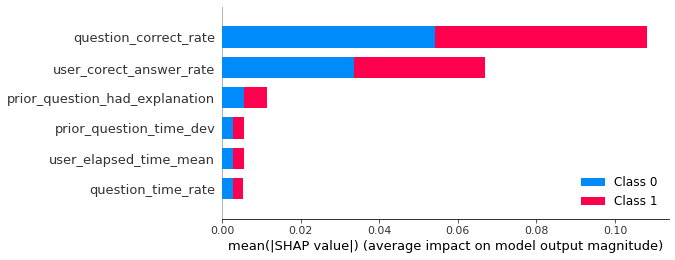

In [18]:
shap.summary_plot(shap_values, valid_features_df, plot_type="bar",
                  title = "")

# Predictions

In [23]:
import riiideducation
env = riiideducation.make_env()

ModuleNotFoundError: No module named 'riiideducation'

In [ ]:
# Here you would also add your pretrained model
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    # --- PREPROCESSING ---
    # Here is time to apply the preprocessing to the test_df
    test_df = merge_data(test_df, questions_df, data_type='test')
    test_df, last_answers = get_answer_time_characteristics(test_df, last_answers)
    test_df = get_features_df(test_df, q_chars, questions_df)
    
    # --- MODEL ---
    test_df['answered_correctly'] = lgbm_2.predict(test_df, num_iteration = lgbm_2.best_iteration)
    env.predict(test_df.reset_index()[['row_id', 'answered_correctly']])